<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/10_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Paper Replicating

In [2]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version son olarak 1.12+ ve üstü olmalıdır."
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version 0.13+ üstü olmalıdır."
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision verisonlarını güncel hale getirmeliyiz!")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Torchinfo yoksa indirilecek.
try:
    from torchinfo import summary
except:
    print("[INFO] Torchinfo bulanamadı. İndiriliyor.")
    !pip install -q torchinfo
    from torchinfo import summary

# Github'tan dosyalar indirilsin.
try:
    from Module_Files import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Module_Files adlı dosyalar
    print("[INFO] Github dosyaları indiriliyor.")
    !git clone https://github.com/ugursirvermez/PyTorch_Education/
    !mv PyTorch_Education/Module_Files .
    !rm -rf PyTorch_Education
    from Module_Files import data_setup, engine

    # MRDBOURKE'un Helper_Functions'ı
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # Helper_Functions by mrdbourke
    !rm -rf pytorch-deep-learning
    from helper_functions import download_data, set_seeds, plot_loss_curves

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
[INFO] Torchinfo bulanamadı. İndiriliyor.
[INFO] Github dosyaları indiriliyor.
Cloning into 'PyTorch_Education'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 550 (delta 23), reused 3 (delta 3), pack-reused 503 (from 2)
Receiving objects: 100% (550/550), 63.90 MiB | 27.03 MiB/s, done.
Resolving deltas: 100% (116/116), done.
data/pizza_steak_sushi Dosyası olusturuluyor
İndiriliyor...
Sıkıştırılmış dosyada çıkarılıyor...
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Aşama-2: Veri Alma

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Transforma boyutu 224'ten oluşturuldu: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


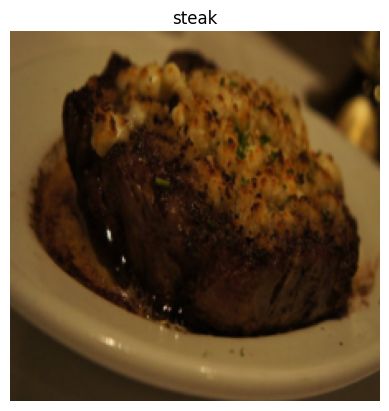

In [4]:
#GitHub MrDbourke içeriğini indiriyoruz.
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
#Train ve Test veri yollarını oluşturuyoruz.
train_dir = image_path / "train"
test_dir = image_path / "test"

#ViT için yükseklik ve genişliği 224x224=4096 haline getirmeliyiz.
IMG_SIZE = 224

# Elle Transform'u oluşturalım.
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Transforma boyutu 224'ten oluşturuldu: {manual_transforms}")

# Batch Miktarı
BATCH_SIZE = 32 #Normalde 4096 olmalı ama yüksek bir sistemimiz yok. Dolayısıyla 32'de kalacağız.

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Yukarıda oluşturduğumuz transform ile devam edeiyoruz.
    batch_size=BATCH_SIZE
)

# GÖRSELLEŞTİRME YAPALIM
# Resimlerin batch'te olanlarını alalım.
image_batch, label_batch = next(iter(train_dataloader))

# Batch'ten bir resim alalım.
image, label = image_batch[0], label_batch[0]

# Görselleştirelim.
plt.imshow(image.permute(1, 2, 0)) #  [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

##Aşama-3: Verileri Bölme Sınıf, Konum ve Patch Ayarlama

In [5]:
# Örnek bir Veri Oluşturalım.
height = 224 # H
width = 224 # W
color_channels = 3 # C -> Renk kanalları
patch_size = 16 # P

# Patch sayısını oluşturma
number_of_patches = int((height * width) / patch_size**2)
print(f"Patch Sayısı (N) with Resim Yüksekliği (H={height}), Genişliği (W={width}) ve Patch Miktarı (P={patch_size}): {number_of_patches}")

Patch Sayısı (N) with Resim Yüksekliği (H=224), Genişliği (W=224) ve Patch Miktarı (P=16): 196


In [6]:
# Girdi biçimi (Input Shape) -> H, W, C
embedding_layer_input_shape = (height, width, color_channels)

# Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Girdi biçimi (Input Shape) -> H, W, C: {embedding_layer_input_shape}")
print(f"Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: {embedding_layer_output_shape}")

Girdi biçimi (Input Shape) -> H, W, C: (224, 224, 3)
Çıktı biçimi (Output Shape) -> Patches, Patch X Patch X C: (196, 768)


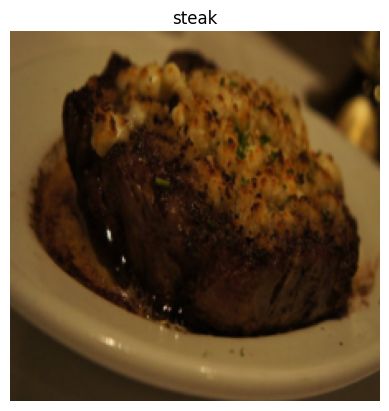

In [7]:
# Resmi Görüntüleme
plt.imshow(image.permute(1, 2, 0)) #Output Shape
plt.title(class_names[label])
plt.axis(False);

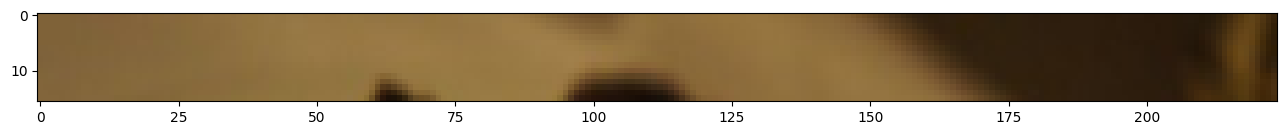

In [8]:
#(color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Patch miktarı belirtelim ve pikselleri görelim.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Her Satırdaki patch sayısı: 14.0
Patch boyutu: 16 pixel x 16 pixel


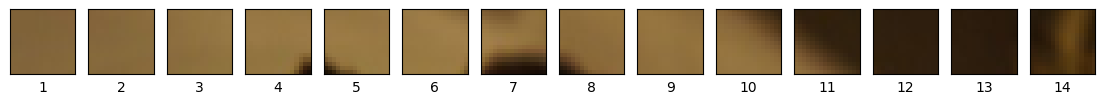

In [9]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Her Satırdaki patch sayısı: {num_patches}\nPatch boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # bir sütundaki her bir patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Resimleri etiketleri ile yan yana görüntüleyelim.
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # Yükseklik ve genişlik yan yana
    axs[i].set_xlabel(i+1) # Etiket
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Satırdaki Patch Sayısı: 14.0        
Sütundaki Patch Sayısı: 14.0        
Toplam Patch Sayısı: 196.0        
Patch Boyutu: 16 pixel x 16 pixel


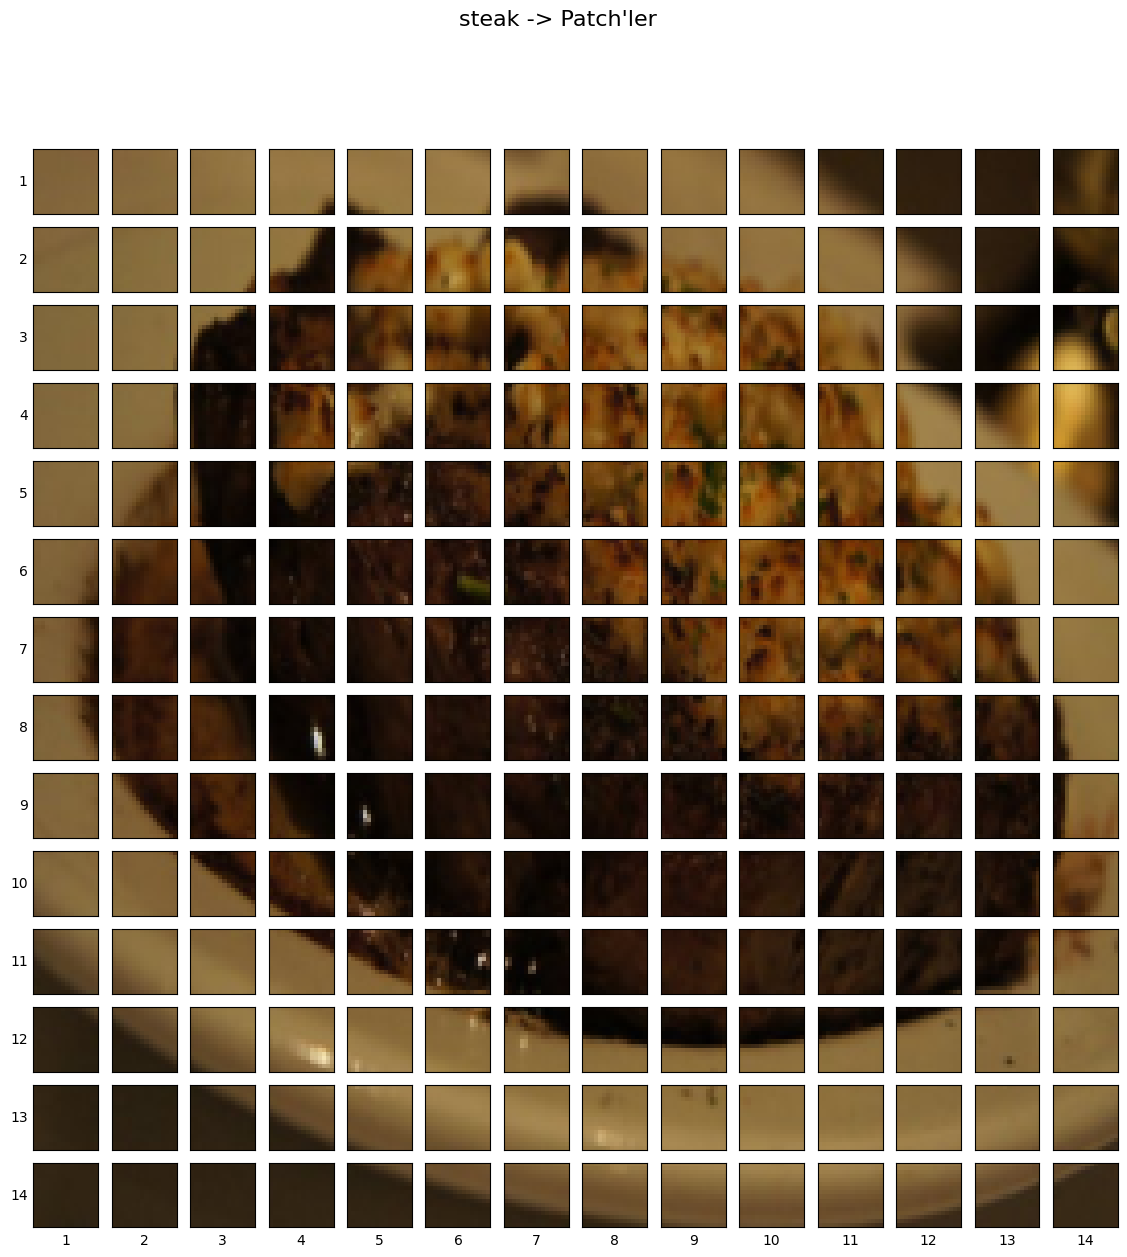

In [10]:
# img_size ve patch_size değerlerini yazıyoruz. Burada bir karşılaştırma yapabiliriz.
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Resim boyutu, patch boyutuna bölümünden kalan sıfır olana kadar"
print(f"Satırdaki Patch Sayısı: {num_patches}\
        \nSütundaki Patch Sayısı: {num_patches}\
        \nToplam Patch Sayısı: {num_patches*num_patches}\
        \nPatch Boyutu: {patch_size} pixel x {patch_size} pixel")

# Patch'leri görüntülemek için bir plot dizisi oluşturalım.
fig, axs = plt.subplots(nrows=img_size // patch_size, # int değerinde olmalı, float olamaz!
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Döngüler halinde her bir patch'i resmin yükseklik ve genişliğine oranla yerleştirelim.
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        # image_permuted -> (Height, Width, Color Channels)
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])

        # Etiketleri yazdırma
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Grafiğe Ana Başlık
fig.suptitle(f"{class_names[label]} -> Patch'ler", fontsize=16)
plt.show()

5 Evrimsel Boyut: [366, 236, 693, 190, 106]


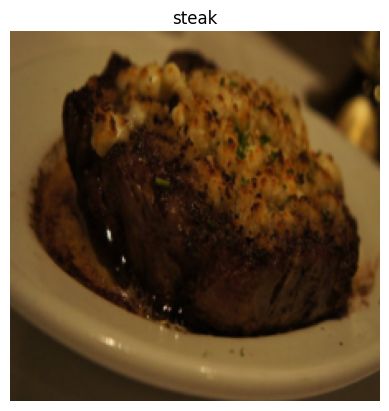

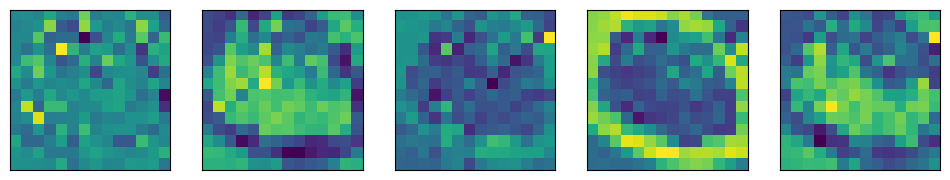

In [11]:
from torch import nn

# Patch Miktarı
patch_size=16

# Conv2d katmanı fakat ViT'nin istediği değerlerde yani channel X Patch x Patch
conv2d = nn.Conv2d(in_channels=3, # renk kanal sayısı
                   out_channels=768, # Embed size
                   kernel_size=patch_size, # patch_size, patch_size
                   stride=patch_size,
                   padding=0)

# Resmi görelim
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

# convolutional layer'da boyut ekleyelim.
image_out_of_conv = conv2d(image.unsqueeze(0)) #(height, width, color_channels) -> (batch, height, width, color_channels)
# Rasgele 5 Evrimsel Boyut Ekleyelim.
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"5 Evrimsel Boyut: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))
# Görselleştirelim.
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [12]:
# Tek bir öğrenme verisinin değerlerine bakalım.
single_feature_map = image_out_of_conv[:, 0, :, :]
print(single_feature_map, single_feature_map.requires_grad)

tensor([[[-0.5305, -0.5502, -0.5847, -0.6174, -0.6193, -0.6223, -0.5009,
          -0.5407, -0.5948, -0.5539, -0.3111, -0.1926, -0.1783, -0.2256],
         [-0.5277, -0.5522, -0.5950, -0.4184, -0.2596, -0.5203, -0.4242,
          -0.3561, -0.4903, -0.5927, -0.5667, -0.4227, -0.1813, -0.1157],
         [-0.5398, -0.5698, -0.2091, -0.1418, -0.2866, -0.3046, -0.2252,
          -0.4056, -0.4625, -0.3784, -0.4871, -0.2906, -0.1018, -0.4163],
         [-0.5463, -0.5503, -0.1243, -0.2030, -0.3933, -0.2081, -0.3937,
          -0.3401, -0.3645, -0.3553, -0.3406, -0.5683, -0.4151, -0.6630],
         [-0.5443, -0.4579, -0.1445, -0.1704, -0.1913, -0.1722, -0.2363,
          -0.3301, -0.3947, -0.4439, -0.3970, -0.4154, -0.6464, -0.4945],
         [-0.5168, -0.2443, -0.1691, -0.0974, -0.1588, -0.1653, -0.1437,
          -0.3159, -0.2669, -0.3514, -0.4075, -0.3145, -0.4248, -0.5889],
         [-0.4784, -0.1673, -0.1547, -0.0974, -0.1301, -0.1557, -0.2193,
          -0.1612, -0.2346, -0.3592, -0.3401,

In [13]:
# Tensörümüzün Şekli
print(f"Mevcut Tensör Şeklimiz: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Mevcut Tensör Şeklimiz: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [14]:
#Flatten Katman Oluşturma
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (boyut 2)
                     end_dim=3) # flatten feature_map_width (boyut 3)

Resmin İlk Şekli: torch.Size([3, 224, 224])
Resmin Özellik Şekli: torch.Size([1, 768, 14, 14])
Flatten Edilmiş Görselin Şekli: torch.Size([1, 768, 196])


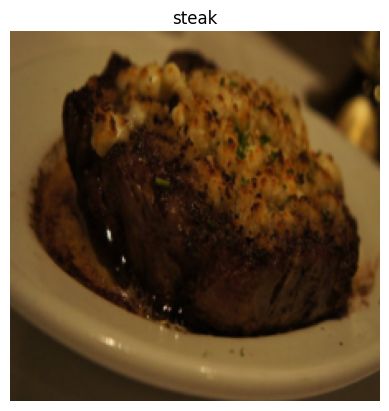

In [16]:
# 1. Single Resimi Alalım
plt.imshow(image.permute(1, 2, 0)) # matplotlib'te görünecek hale getirelim.
plt.title(class_names[label]) #Etiketleri yazdır.
plt.axis(False);
print(f"Resmin İlk Şekli: {image.shape}")

# 2. Özellikleri Haritalaştıralım
image_out_of_conv = conv2d(image.unsqueeze(0)) #batch'e bir boyut ekleyip şekil hatalarından kaçınalım.
print(f"Resmin Özellik Şekli: {image_out_of_conv.shape}")

# 3. Flatten Edilmiş Görselin Şekli
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flatten Edilmiş Görselin Şekli: {image_out_of_conv_flattened.shape}")

In [17]:
 #196, 768 değerlerinin yerini değiştireceğiz.
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Sekans boyutunun Değişimi: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Sekans boyutunun Değişimi: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


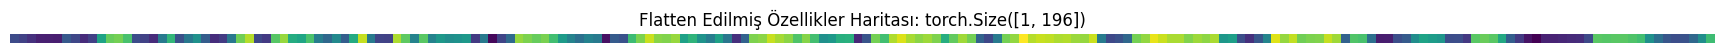

In [18]:
# flatten edilmiş özellikler haritası (Tek satır)
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Yukarıdaki değişkeni görselleştirelim
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flatten Edilmiş Özellikler Haritası: {single_flattened_feature_map.shape}")
plt.axis(False);

In [20]:
# 1.Adım: nn.Module'den bir Patch için çalışacak sınıf oluşturalım.
class PatchEmbedding(nn.Module):
    """2D bir resmi tek boyutlu bir metin vektörüne çevireceğiz.

    Args:
        in_channels (int): Renk kanallarıdır. Minimum, başlangıç değerini 3 alacağız.
        patch_size (int): Patch miktarını input'a çevirecek. başlangıç değerini 16 alacağız.
        embedding_dim (int): Embed edilecek boyutlar. başlangıç değerini 768 alacağız.
    """
    # 2.Adım: Modülde çalışacak değişkenlerimizi tanımlayalım.
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3.Adım: conv2d ile resmi patch'lere bölelim.
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4.Adım: Flatten ederek resmi tek bir boyuta düzleştirmek için bir katman oluşturalım.
        self.flatten = nn.Flatten(start_dim=2, # Tek bir vektöre dönüşecek.
                                  end_dim=3)

    # 5.Adım: Forward metodu, klasik.
    def forward(self, x):
        # Resim kalitesinden ödün vermemek için şekli düzenleyelim.
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Resim patch miktarına bölünecek. Resmin Şekli: {image_resolution}, Patch Miktarı: {patch_size}"

        # Forward Edelim.
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6.Adım: Resmin çıktı şeklini kontrol edelim.
        return x_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

#ÇALIŞTIRALIM...
# Patch embed katmanlı değişken tasarlayalım.
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Bir resmi çalıştıralım.
print(f"Input Shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # Hata çıkmaması için katman ekledik.
print(f"Output patch embed shape: {patch_embedded_image.shape}")

Input Shape: torch.Size([1, 3, 224, 224])
Output patch embed shape: torch.Size([1, 196, 768])


In [21]:
# Rastgele girdi veri oluşturalım.
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

# Summary ile, Patch Embedding'in katmanlarına bakalım.
summary(PatchEmbedding(),
         input_size=random_input_image,
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [22]:
# Batch miktarı ve embedding boyutunu alalım
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Embedding'ler için her bir boyuta bir token oluşturalım.
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # embed edileni öğretilebilir hale getiriyoruz.

# class_token değişkeninin ilk 10 birimini yazdıraım.
print(class_token[:, :, :10])
print(f"class_token Biçimi: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class_token Biçimi: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]
